In [1]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

## Setup

### Import libraries

In [2]:
from fastcore.utils import *
from fastcore.test import *

from ids_finder.utils import *
from ids_finder.core import pl_norm

from datetime import timedelta

import polars as pl
import pandas as pd
import numpy as np

import seaborn as sns
import altair as alt
import vegafusion as vf
vf.enable(row_limit = int(1e6))

vegafusion.enable(mimetype='html', row_limit=1000000, embed_options=None)

### Connect `python` with `R` kernel

You can install the package with `pip install rpy2 rpy2-arrow`

In [3]:
%load_ext rpy2.ipython

08-Oct-23 00:39:18: cffi mode is CFFI_MODE.ANY
08-Oct-23 00:39:18: R home found: /Library/Frameworks/R.framework/Resources
08-Oct-23 00:39:18: R library path: 
08-Oct-23 00:39:18: LD_LIBRARY_PATH: 
08-Oct-23 00:39:18: Default options to initialize R: rpy2, --quiet, --no-save
08-Oct-23 00:39:18: R is already initialized. No need to initialize.


In [4]:
import rpy2
import rpy2_arrow.arrow as pyra
from rpy2.robjects.packages import importr

In [5]:
%%R
library(ggplot2)
library(ggpubr)
library(viridis)

library(glue)
library(arrow)

Loading required package: viridisLite


In [6]:
#| code-summary: helper functions to convert between `python` and `R` dataframes

base = importr('base')

conv_pl = rpy2.robjects.conversion.Converter(
    'Pandas to pyarrow',
    template=pyra.converter)

@conv_pl.py2rpy.register(pl.DataFrame)
def py2rpy_pandas(dataf: pl.DataFrame):
    pa_tbl = dataf.to_arrow()
    return base.as_data_frame(pa_tbl)
    # return pyra.converter.py2rpy(pa_tbl) # NOTE: not working for ggplot2

conv_pl = rpy2.ipython.rmagic.converter + conv_pl

### Read all candidates from different sources

In [7]:
tau = timedelta(seconds=60)

jno_fp = Path(f'../data/jno_candidates_tau_{tau.seconds}.parquet')
thb_fp = Path(f'../data/thb_candidates_sw_tau_{tau.seconds}.parquet')
sta_fp = Path(f'../data/sta_candidates_tau_{tau.seconds}.parquet')


jno_candidates = pl.scan_parquet(jno_fp).collect()
thb_candidates = pl.scan_parquet(thb_fp).collect()
sta_candidates = pl.scan_parquet(sta_fp).collect()

# jno_data_fp = Path(f'../data/jno_data_*.parquet')

# jno_data = pl.scan_parquet(jno_data_fp)

In [9]:
if Path("../data/candidates.csv").exists():
    all_candidates = pl.read_csv("../data/candidates.csv")
else:
    all_candidates = pl.concat(
    [
        jno_candidates.with_columns(sat=pl.lit("JNO")),
        thb_candidates.with_columns(sat=pl.lit("THB")),
        sta_candidates.with_columns(sat=pl.lit("STA")).with_columns(pl.selectors.float().cast(pl.Float64)),
    ],
    how="diagonal"
)
    all_candidates.write_csv()

In [10]:
from astropy import constants as const
au_in_km = const.au.to("km").value

jno_dist_cols = ["X", "Y", "Z"]

jno_candidates = jno_candidates.with_columns(
    pl_norm(jno_dist_cols).alias("distance"),
).with_columns(
    (pl.col(["X", "distance"]) / au_in_km).map_alias(lambda col: col+"_in_AU"),
).sort("time")

jno_candidates_filtered = jno_candidates.filter(
        pl.col("time") < pd.Timestamp("2016-05-01") # There is a sudden increase in the number of TD candidates after this date
)

In [11]:
%R -i jno_candidates -c conv_pl
%R -i thb_candidates -c conv_pl
%R -i sta_candidates -c conv_pl
%R -i jno_candidates_filtered -c conv_pl

## Profiling

In [ ]:
from ydata_profiling import ProfileReport

In [ ]:
jno_candidates.columns

In [ ]:
df = jno_candidates.select(["time", 'index_diff', "B", 'B_n', 'BnOverB', 'dB', 'dBOverB', 'rotation_angle', 'type', "X"]).to_pandas()

In [ ]:
profile = ProfileReport(df, title="JUNO Candidates Report")
profile.to_file("jno.html")

In [ ]:
from functools import reduce

@patch
def sel(self: pl.LazyFrame | pl.DataFrame, **kwargs):
    predicates = []
    for k, v in kwargs.items():
        if isinstance(v, slice):
            predicate = pl.col(k).is_between(v.start, v.stop)
        else:
            predicate = pl.col(k) == v
        predicates.append(predicate)
    
    return self.filter(reduce(operator.and_, predicates))

## Analysis

#### Utils

In [22]:
def truncate_time(data: pl.LazyFrame, every, col_name='time'):
    return data.with_columns(pl.col(col_name).dt.truncate(every).alias("truncated_time"))

In [21]:
%%R
# Save the plot, if filename is provided
save_plot <- function(filename = NULL) {
  if (!is.null(filename)) {
    ggsave(filename = glue("../figures/{filename}.png"))
    ggsave(filename = glue("../figures/{filename}.pdf"))
  }
}

### Magnetic field strength vs. distance

In [ ]:
%%markdown

file = f"../data/jno_*.parquet"
lazy_df = pl.scan_parquet(file)

In [ ]:
%%markdown
b_cols = ["BX", "BY", "BZ"]

every = "3d"
b_df = (
    lazy_df.with_columns(
        pl_norm(b_cols).alias("B"),)
    .sort("time")
    .group_by_dynamic("time", every=every)
    .agg(
        pl.mean("B").alias("B_mean"),
    )
    .collect()
)

In [ ]:
%%markdown
alt.Chart(b_df).mark_line().encode(
    x="time",
    y="B_mean",
)

In [ ]:
%%markdown
binwidth = 0.1

b_df = (
    lazy_df.with_columns(
        (pl.col('X')/au_in_km / binwidth).floor().alias('bin_group_id').cast(pl.Int64),
        pl_norm(b_cols).alias("B"),
    ).group_by("bin_group_id").agg(
        pl.mean("B").alias("B_mean"),
    ).with_columns(
        (pl.col("bin_group_id") * binwidth).alias("binned_distance"),
    ).collect()
)

In [ ]:
%%markdown

alt.Chart(b_df).mark_line().encode(
    x=alt.X("binned_distance").title("Distance from Sun (AU)"),
    y=alt.Y("B_mean").title("Magnetic Field Strength (nT)"),
)

### Distance and Occurrence rates versus time

In [263]:
%%markdown
properties = {'width': 900, 'height': 150}

chart1 = alt.Chart(candidates_pl).mark_point().encode(
    x=alt.X('yearmonthdate(time)').axis(labels=False, title=None),
    y=alt.Y('mean(distance_in_AU)').axis(title='Distance (AU)'),
).properties(**properties)

chart2 = alt.Chart(candidates_pl).mark_point().encode(
    x='yearmonth(time)',
    y='count()',
    color = 'type',
    row='type'
).properties(**properties)

chart1 & chart2

properties = {'width': 900, 'height': 150}

chart1 = alt.Chart(candidates_pl).mark_point().encode(
    x=alt.X('yearmonthdate(time)').axis(labels=False, title=None),
    y=alt.Y('mean(distance_in_AU)').axis(title='Distance (AU)'),
).properties(**properties)

chart2 = alt.Chart(candidates_pl).mark_point().encode(
    x='yearmonth(time)',
    y='count()',
    color = 'type',
    row='type'
).properties(**properties)

chart1 & chart2


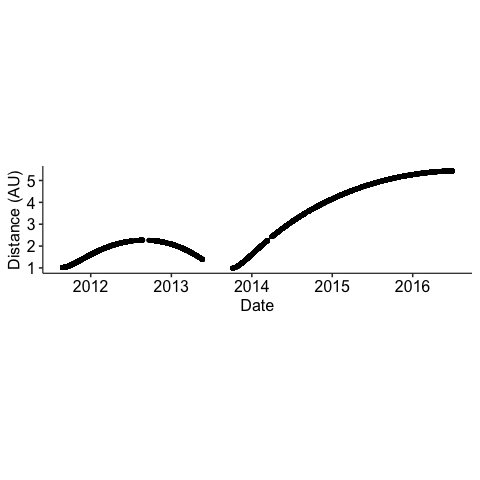

In [11]:
%%R -i jno_candidates -c conv_pl

p <- ggplot(jno_candidates, aes(x = time, y = distance_in_AU)) + 
  geom_point() + # Plot distance by date
  labs(x = "Date", y = "Distance (AU)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)

print(p)

# save_plot(filename = "distance_by_date")

The following codes deal with data gap better by filling the gap with the `null` value.

In [12]:
every = pd.Timedelta("3d")
base_amplification_factor = every / pd.Timedelta("1d")

df = (
    jno_candidates_filtered.pipe(truncate_time, every=every)
    .group_by("truncated_time")
    .agg(
        pl.count() / base_amplification_factor,
        pl.mean("distance_in_AU"),
    )
    .upsample("truncated_time", every=every)
)

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


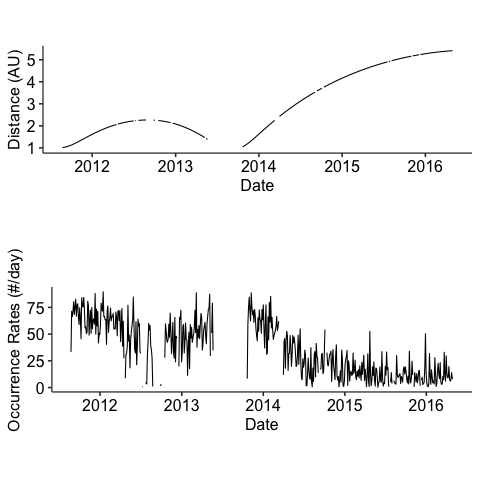

In [24]:
%%R -i df -c conv_pl

df$date <- as.Date(df$truncated_time)
p1 <- ggplot(df, aes(x = date, y = distance_in_AU)) + 
  geom_line() + # Plot distance by date
  labs(x = "Date", y = "Distance (AU)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)
  
p2 <- ggplot(df, aes(x = date, y = count)) + 
  geom_line() + # Plot distance by date
  labs(x = "Date", y = "Occurrence Rates (#/day)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)

p <- ggarrange(p1, p2, nrow = 2)

save_plot("distance_and_or")
p

### Classification of candidates

In [ ]:
sns.jointplot(
    jno_candidates,
    x='dBOverB', y='BnOverB',
    # kind='kde',
    kind="hex",
)

In [ ]:
sns.jointplot(
    all_candidates,
    x='dBOverB', y='BnOverB',
    # kind='kde',
    kind="hex",
)

### Distribution of the DD types

##### Plot distribution of types for each missions


In [ ]:
alt.Chart(all_candidates).encode(
    x=alt.X("count()").stack("normalize").title("Share of ID types"),
    y=alt.Y('sat').title(None),
    color='type',
).mark_bar()

# alt.Chart(distributions).encode(
#     alt.X('ratio:Q', title='DD type distribution').axis(format='.0%'),
#     y=alt.Y('sat', title=None),
#     color='type',
# ).mark_bar()

In [ ]:
distributions = all_candidates.group_by("sat", "type").agg(pl.count()).with_columns(
    (pl.col("count") / pl.sum("count").over("sat")).alias("ratio")
)
count_table = distributions.to_pandas().pivot(index='sat', columns='type', values='count')[['RD', 'TD', 'ED', 'ND']]
ratio_table = distributions.to_pandas().pivot(index='sat', columns='type', values='ratio')[['RD', 'TD', 'ED', 'ND']]
# display(distributions.to_pandas().pivot(index='sat', columns='type', values='ratio')[['RD', 'TD', 'ED', 'ND']].style.format("{:.0%}"))
display(count_table, ratio_table.style.format("{:.0%}"))


##### Plot distribution of types for each missions **over time**

In [ ]:
alt.Chart(all_candidates).mark_bar(binSpacing=0).encode(
    x="yearmonth(time)",
    y=alt.Y("count()").stack("normalize").title("Share of ID types"),
    row=alt.Row("sat").title(None),
    color="type",
).configure_axis(grid=False).properties(height=100)

In [ ]:
%%R
plot_type_distribution <- function(data, bin_width = 30) { 
    data$date_only <- as.Date(data$time)
    
    p <- ggplot(data, aes(date_only, fill = type)) +
        geom_histogram(binwidth = bin_width, position = "fill") + 
        theme_pubr(base_size = 16)
        
    return(p)
}

p1 <- plot_type_distribution(jno_candidates)
p2 <- plot_type_distribution(thb_candidates)
p3 <- plot_type_distribution(sta_candidates)

p <- ggarrange(
    p1 + rremove("xlab"),
    p2 + rremove("xlab"), p3, 
    nrow = 3, align = 'hv', 
    labels=list("JUNO", "ARTEMIS-B", "STEREO-A"), hjust=0, vjust=0,
    legend = 'right', common.legend = TRUE
)
# save_plot(filename = "type_distribution")
p

### Occurrence rates versus time of different types

Plot the occurernce rate of each type of IDs as a function of time

In [ ]:
%%R
plot_count_raw <- function(data, bin_width = 5) {
  # Transform date column
  data$date_only <- as.Date(data$time)
  
  # Plot
  p <- ggplot(data, aes(x = date_only)) + 
    geom_freqpoly(aes(color = "All"), binwidth = bin_width) + # Overall frequency by day
    geom_freqpoly(aes(color = type), binwidth = bin_width) + # Frequency by day split by type
    labs(x = "Date") +
    theme_pubr(base_size = 16) +
    theme(
      aspect.ratio=0.25,
      )
  
  # Print the plot
  print(p)
  
  return(p)
}

In [ ]:
%%R
p1 <- plot_count_raw(jno_candidates)
p2 <- plot_count_raw(thb_candidates)
p3 <- plot_count_raw(sta_candidates)

p <- ggarrange(
    p1 + rremove("xlab"),
    p2 + rremove("xlab"), p3, 
    nrow = 3, align = 'hv', 
    labels=list("JUNO", "ARTEMIS-B", "STEREO-A"), hjust=0,
    legend = 'right', common.legend = TRUE)

# save_plot("count_raw_multi")
p

As we can see different types of IDs have different Occurrence rates. To demonstrate their relative change, amplify TD-like IDs by 10 times.

In [ ]:
import pandas as pd
import polars as pl

In [ ]:
def get_count_by_type(candidates: pl.DataFrame, truncation_delta="5d"):
    every = pd.Timedelta(truncation_delta)
    base_amplification_factor = every / pd.Timedelta("1d")
    amplification_factors = {
        "RD": 1 / base_amplification_factor,
        "ED": 1 / base_amplification_factor,
        "TD": 10 / base_amplification_factor,
        "ND": 10 / base_amplification_factor,
    }

    temp_df = (
        candidates.pipe(truncate_time, every=every)
        .group_by("truncated_time", "type")
        .agg(
            pl.count(),
        )
    )

    type_dfs = []
    for type, group in temp_df.group_by("type"):
        type_df = (
            group.sort("truncated_time")
            .upsample("truncated_time", every=every)
            .with_columns(
                pl.col("type").fill_null(type),
                pl.col("count") * amplification_factors[type],
            )
        )
        type_dfs.append(type_df)

    df = pl.concat(type_dfs)
    return df

In [ ]:
%%R
plot_count_am <- function(df) {
  tmp <- df %>%
    mutate(name2=type)
  tmp$date <- as.Date(tmp$truncated_time)
  tmp$type <- factor(tmp$type, levels = c("RD", "ED", "TD", "ND"))

  p <- tmp %>%
    ggplot( aes(date, count)) +
      geom_line( data=tmp %>% dplyr::select(-type), aes(group=name2), color="grey", linewidth=0.5, alpha=0.5) +
      geom_line( aes(color=type), color="#69b3a2")+
      facet_grid(type ~ .) +
      labs(x = "Date", y = "Occurrence Rates (#/day)") +
      theme_pubr(base_size = 16) +
      theme(aspect.ratio=0.25)
  return(p)
}

In [ ]:
jno_count_filtered_df = get_count_by_type(jno_candidates_filtered)


In [ ]:
%%R -i jno_count_filtered_df -c conv_pl
plot_count_am(jno_count_df)
# save_plot('jno_count_am')

In [ ]:
thb_count_df = get_count_by_type(
    thb_candidates
)

In [ ]:
%%R -i thb_count_df -c conv_pl
plot_count_am(thb_count_df)
# save_plot('thb_count_am')

#### Histogram of Occurrence rates (not normalized)

In [ ]:
jno_candidates_rd_like = jno_candidates.filter(
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

jno_candidates_td_like = jno_candidates.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

thb_candidates_rd_like = thb_candidates.filter(
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

thb_candidates_td_like = thb_candidates.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

In [ ]:
%R -i jno_candidates -c conv_pl
%R -i jno_candidates_rd_like -c conv_pl
%R -i jno_candidates_td_like -c conv_pl
%R -i thb_candidates -c conv_pl
%R -i thb_candidates_rd_like -c conv_pl
%R -i thb_candidates_td_like -c conv_pl

In [ ]:
%%R

p1 <- gghistogram(jno_candidates, x = "time",
   rug = TRUE,
   color = "type", fill = "type",
   )

p2 <- gghistogram(jno_candidates_rd_like, x = "time",
   rug = TRUE,
   color = "type", fill = "type",
   )

p3 <- gghistogram(jno_candidates_td_like, x = "time",
   rug = TRUE,
   color = "type", fill = "type",
   )

p <- ggarrange(p1, p2, p3, nrow = 3)
p

#### Histogram of Occurrence rates (normalized)

In [ ]:
def normalize_count(
    count_df: pl.DataFrame | pl.LazyFrame,  # the dataframe with count to be normalized
    data: pl.DataFrame | pl.LazyFrame,  # the data used to calculate the duration ratio
    s_resolution,
    l_resolution,
):
    duration_df = (
        data.lazy()
        .group_by_dynamic("time", every=s_resolution)
        .agg(pl.lit(1).alias("availablity"))
        .group_by_dynamic("time", every=l_resolution)
        .agg(
            (pl.sum("availablity") * s_resolution / l_resolution).alias(
                "duration_ratio"
            )
        )
    )

    count_normalized_df = (
        count_df.lazy()
        .join(duration_df, left_on="truncated_time", right_on="time", how="left")
        .with_columns((pl.col("count") / pl.col("duration_ratio")).alias("count"))
    )

    return count_normalized_df.collect()

In [ ]:
s_resolution = timedelta(minutes=1)
l_resolution = timedelta(days=30)

In [ ]:
sat = 'jno'
files = f"../data/{sat}_data_*.parquet"

data = pl.scan_parquet(files).set_sorted('time')
jno_count_filtered_df = get_count_by_type(jno_candidates_filtered, l_resolution)
jno_count_normalized_filtered_df = normalize_count(jno_count_filtered_df, data, s_resolution, l_resolution)

In [ ]:
sat = 'thb'
files = f"../data/{sat}_data_sw.parquet"

data = pl.scan_parquet(files).set_sorted('time').collect()
thb_count_df = get_count_by_type(thb_candidates, l_resolution)
thb_count_normalized_df = normalize_count(thb_count_df, data, s_resolution, l_resolution)

In [ ]:
sat = 'STA'
files = f"../data/{sat}_data_downsampled.parquet"

data = pl.scan_parquet(files).set_sorted('time').collect()
sta_count_df = get_count_by_type(sta_candidates, l_resolution)
sta_count_normalized_df = normalize_count(sta_count_df, data, s_resolution, l_resolution)

In [ ]:
%R -i thb_count_normalized_df -c conv_pl
%R -i sta_count_normalized_df -c conv_pl
%R -i jno_count_normalized_df -c conv_pl

In [ ]:
%%R
p1 <- plot_count_am(jno_count_normalized_df)

In [ ]:
%%R
p1_f <- plot_count_am(jno_count_normalized_filtered_df)
p1_f
# save_plot("count_am_jno_filtered")

In [ ]:
%%R
p2 <- plot_count_am(thb_count_normalized_df)
save_plot("count_am_thb")

In [ ]:
%%R
p3 <- plot_count_am(sta_count_normalized_df)
save_plot("count_am_sta")

### Occurrence rates versus distance

In [ ]:
temp_candidates_pl = jno_candidates.filter(
    pl.col("time") > pd.Timestamp("2013-06-01")  # Where distance increases singularly
)

In [ ]:
%%R -i temp_candidates_pl -c conv_pl
gghistogram(temp_candidates_pl, x="distance_in_AU", rug=TRUE, color="type", fill="type", binwidth=0.1) + 
  labs(x="Distance (AU)", y="Count")

In [ ]:
jno_candidates_rd_like = temp_candidates_pl.filter(  
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

jno_candidates_td_like = temp_candidates_pl.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

In [ ]:
%%R -i candidates_rd_like -c conv_pl

gghistogram(candidates_rd_like, x="distance_in_AU", rug=TRUE, color="type", fill="type", binwidth=0.1) + 
  labs(x="Distance (AU)", y="Count") +
  theme_pubr(base_size = 16)

In [ ]:
%%R -i candidates_td_like -c conv_pl

gghistogram(candidates_td_like, x="distance_in_AU", rug=TRUE, color="type", fill="type", binwidth=0.1) + 
  labs(x="Distance (AU)", y="Count") +
  theme_pubr(base_size = 16)

In [ ]:
binwidth = 0.1
temp_df = temp_candidates_pl.with_columns(
    (pl.col('distance_in_AU')/binwidth).floor().alias('bin_group_id').cast(pl.Int64),
).group_by("bin_group_id",'type').agg(
    (pl.max("time") - pl.min("time")).alias("duration"),
    pl.col('distance_in_AU').mean().alias("mean_distance"),
    pl.count()
).with_columns(
    (pl.col("duration") / pd.Timedelta(hours=24)).alias("duration_in_days"),
).filter(
    pl.col("duration_in_days") > 1 # filter out candidates that occur within 1 day
).with_columns(
    (pl.col("count") / pl.col("duration_in_days")).alias("occurrence_rate")
).sort(
    "bin_group_id"
)

In [ ]:
_ = pl.DataFrame({'bin_group_id': pl.arange(temp_df['bin_group_id'].min(), temp_df['bin_group_id'].max()+1, eager=True)})

type_dfs = []
for type, jno_fp in temp_df.group_by("type"):
    type_df = _.join(jno_fp, on="bin_group_id", how="left").with_columns(
            pl.col("type").fill_null(type),
        )
    type_dfs.append(type_df)

or_df = pl.concat(type_dfs).with_columns(
    (pl.col("bin_group_id") * binwidth).alias("binned_distance"),
)

In [ ]:
%%R -i or_df -c conv_pl
p <- ggplot(or_df, aes(x=binned_distance, y=occurrence_rate, color=type)) +
    geom_point() +
    geom_line() +
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

In [ ]:
jno_candidates_rd_like = or_df.filter(
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

jno_candidates_td_like = or_df.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

In [ ]:
%%R -i candidates_rd_like -c conv_pl
p <- ggplot(candidates_rd_like, aes(x=binned_distance, y=occurrence_rate, color=type)) +
    geom_point() +
    geom_line() +
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance_rd"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

In [ ]:
%%R -i candidates_td_like -c conv_pl
p <- ggplot(candidates_td_like, aes(x=binned_distance, y=occurrence_rate, color=type)) +
    geom_point() +
    geom_line() +
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance_td"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

In [ ]:
%%R -i candidates_rd_like -c conv_pl
p <- ggscatter(candidates_rd_like, x = "mean_distance", y = "occurrence_rate",
        color = "type",
        add = "loess",  # Add regressin line
        add.params = list(fill = "lightgray"), # Customize reg. line
        shape = 21, size=3, # Points color, shape and size
        conf.int = TRUE, # Add confidence interval
        cor.coef = TRUE, # Add correlation coefficient. see ?stat_cor
        cor.coeff.args = list(method = "pearson", label.x = 3, label.sep = "\n")
    ) + 
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance_rd"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

In [ ]:
%%R -i candidates_td_like -c conv_pl
p <- ggscatter(candidates_td_like, x = "mean_distance", y = "occurrence_rate",
        color = "type",
        add = "loess",  # Add regressin line
        add.params = list(fill = "lightgray"), # Customize reg. line
        shape = 21, size=3, # Points color, shape and size
        conf.int = TRUE, # Add confidence interval
        cor.coef = TRUE, # Add correlation coefficient. see ?stat_cor
        cor.coeff.args = list(method = "pearson", label.x = 3, label.sep = "\n")
    ) + 
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance_td_fit"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

### $dB_l/B$

- $dB_l/B$ does not show any clear correlation with time.

In [77]:
every = pd.Timedelta("30d")

data = jno_candidates.with_columns(
    (pl_norm(["dB_l", "dB_l", "dB_l"]) / pl.col('B')).alias("dB_vec_over_B"),
    (pl.col("dB_l") / pl.col('B') ).abs().alias("dB_l_over_B"),
).pipe(truncate_time, every=every)

%R -i data -c conv_pl

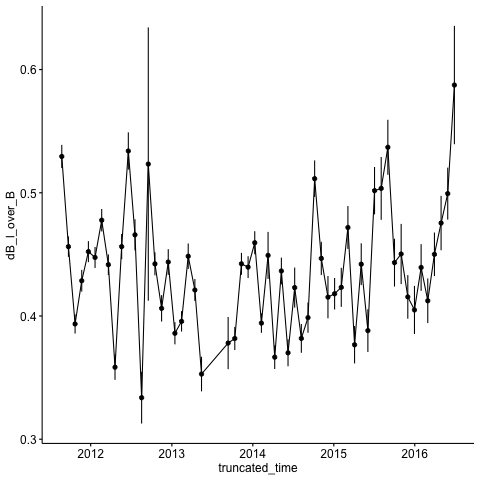

In [235]:
%%R
p1 <- ggline(
    data, x = "truncated_time", y = "dB_l_over_B",
    add = c("mean_se")
)

p1
# p2 <- ggplot(data, aes(x=truncated_time, y=dB_l_over_B) ) +
#   geom_bin2d()

# ggarrange(p1, p2, nrow=2)

No clear trend is found. Let see if there is any trend in the distribution of $dB_l/B$.

In [242]:
base = alt.Chart(data).encode(
    x=alt.X('yearmonth(time)'),
    y=alt.Y('mean(dB_l_over_B)'),
)

heatmap = alt.Chart(data).mark_rect().encode(
    alt.X('yearmonth(time):O'),
    # alt.X('truncated_time:O'), # NOTE: this is not formatted correctly
    alt.Y('dB_l_over_B:Q').bin(maxbins=30),
    alt.Color('count()'),
)

heatmap + base.mark_line()

alt.LayerChart(...)

However the `count` changes a lot with time. We need to normalize by time to see how the distribution of $dB_l/B$ changes with time...

In [245]:
def bin(data: pl.DataFrame, col_name, maxbins=10, start=None, stop=None):
    
    start = start or data.get_column(col_name).min()
    stop = stop or data.get_column(col_name).max()
    bins = np.linspace(start, stop, maxbins)
    
    cut = data.get_column(col_name).cut(
        bins, 
    ).alias("cut")
    return data.with_columns(cut)

def scale(data, col_name = 'count', over_col_name=None):
    return data.with_columns(
        (pl.col(col_name) / pl.sum(col_name).over(over_col_name)).alias("ratio")
    )

In [257]:
binned_data = (
    data.pipe(bin, "dB_l_over_B", maxbins=20, start=0, stop=2)
    .group_by("truncated_time", "cut")
    .agg(pl.count())
    .filter(pl.col("count") > 1)
    .pipe(scale, col_name="count", over_col_name="truncated_time")
)

base = alt.Chart(binned_data).mark_rect().encode(
    alt.X("truncated_time:O"),  # NOTE: this is not formatted correctly
    alt.Y("cut:O").sort("descending"),
    alt.Color("ratio"),
)

base
# Note: no big difference even in log scale
# base.encode(color=alt.Color("ratio").scale(type="log"))

alt.Chart(...)

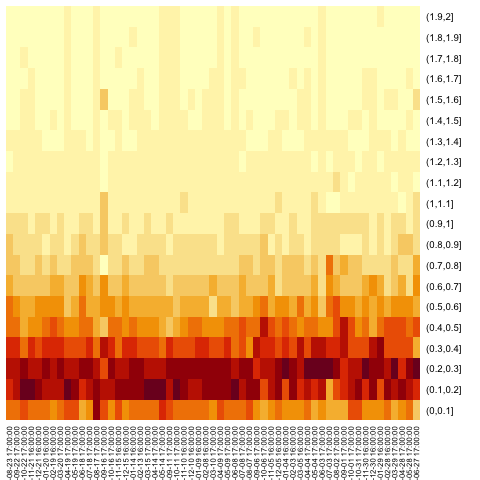

In [239]:

%%R
# 1. Binning and Counting
bins <- 20
min_val <- 0
max_val <- 2
breaks_seq <- seq(min_val, max_val, length.out = bins + 1)  # +1 because for N bins, you need N+1 break points
data$y_bin <- cut(data$dB_l_over_B, breaks = breaks_seq)

# 2. Create a Matrix
mat <- with(data, table(y_bin, truncated_time))

# 4. Plotting using heatmap
heatmap(mat, Colv = NA, Rowv = NA, scale = "column")


## Obsolete codes

### Waiting time

### Amplitude

In [ ]:
temp_candidates = get_candidates(jno_candidates, 'RD')
temp_candidates = pdp_calc_duration(temp_candidates)
temp_candidates

In [ ]:
plot_candidates(temp_candidates)

### RD paramters

In [ ]:
# BUG: `Bm0` may be larger than `radius`

def calculate_RD_parameter(Bl, Bm, Bn=None, num_avg_points=8):
    """Calculate magnetic field parameters for rotation discontinuity (RD) identification.

    Args:
        Bl (xarray.DataArray): 'Bl' component of the magnetic field.
        Bm (xarray.DataArray): 'Bm' component of the magnetic field.
        Bn (xarray.DataArray, optional): 'Bn' component of the magnetic field. Defaults to None.
        num_avg_points (int): Number of points at the start and end of data for averaging.

    Returns:
        tuple: A tuple containing 'Bl_max' and 'Bm0', and 'Bn0' if 'Bn' was provided.
    """
    
    radius = np.sqrt(Bl**2 + Bm**2).mean(dim="time")

    # Calculate 'Bm0'
    Bm_start = Bm[:num_avg_points].mean(dim="time")
    Bm_end = Bm[-num_avg_points:].mean(dim="time")
    Bm0 = (Bm_start + Bm_end) / 2
    
    # Calculate 'Bl_max': average of the absolute values of 'Bl' at the start and end of the data
    # Bl_start = Bl[:num_avg_points].mean(dim="time")
    # Bl_end = Bl[-num_avg_points:].mean(dim="time")
    # Bl_max = (np.abs(Bl_start) + np.abs(Bl_end)) / 2
    
    # Calculate 'Bl_max': using radius, more reliable
    Bl_max = np.sqrt(radius**2 - Bm0**2)

    # Calculate 'Bn0' if 'Bn' is provided, else return 'Bl_max' and 'Bm0' only
    if Bn is not None:
        Bn0 = Bn.mean(dim="time")
        return Bl_max.values, Bm0.values, Bn0.values

    return Bl_max.values, Bm0.values


def RD_parameter(data, tstart, tstop):
    mva(data, tstart, tstop)
    mva_data = get_data("fgm_rot", xarray=True)
        
    Bl = mva_data.sel(v_dim=0)
    Bm = mva_data.sel(v_dim=1)
    Bn = mva_data.sel(v_dim=2)

    Bl_max, Bm0, Bn0 = calculate_RD_parameter(Bl, Bm, Bn)
    return pd.Series({
        'Bl_max':Bl_max, 
        'Bm0': Bm0, 
        'Bn0': Bn0
        })



In [ ]:
pdp.ApplyToRows(lambda row: RD_parameter(juno_fgm_b, row['tstart'], row['tstop']), func_desc='calculating parameters for RD')(jno_candidates)

### TD parameters

$$PVI(t) = B(t + \tau/2) - B(t - \tau/2) = B_+(t) - B_-(t)$$

In [ ]:
def duration_TD(vec: xr.DataArray, threshold_ratio=0.2) -> pd.Series:
    # Calculate magnitude and its difference
    vec_mag = calc_vec_mag(vec)
    vec_mag_diff = vec_mag.differentiate("time")

    # Determine if the trend is increasing or decreasing
    increasing = vec_mag[0] < vec_mag[-1]

    # Determine d_star based on trend
    d_star_index = vec_mag_diff.argmax(dim="time").values if increasing else vec_mag_diff.argmin(dim="time").values
    d_star = vec_mag_diff[d_star_index].values
    d_star_time = vec_mag_diff.time[d_star_index].values
    
    threshold = d_star * threshold_ratio

    # Determine start time
    pre_vec_mag = vec_mag_diff[0:d_star_index]
    condition = pre_vec_mag > threshold if increasing else pre_vec_mag < threshold
    start_index = np.where(condition)[0][0]
    start_time = pre_vec_mag.time[start_index].values
    logger.debug(f'start_index: {start_index}, start_time: {start_time}')

    # Determine stop time
    post_vec_mag = vec_mag_diff[d_star_index:]
    condition = post_vec_mag > threshold if increasing else post_vec_mag < threshold
    end_index = np.where(condition)[0][-1]
    end_time = post_vec_mag.time[end_index].values

    return pd.Series({
        'TD_type': "increasing" if increasing else "decreasing",
        'TD_d_star': d_star,
        'TD_star_time': d_star_time,
        'TD_start': start_time,
        'TD_stop': end_time,
    })

pdp_TD = pdp.PdPipeline([
    pdp.ApplyToRows(lambda candidate: duration_TD(get_candidate_data_xr(candidate)) if candidate['type']=='TD' else None, func_desc='calculating duration parameters of TD'),
])

# duration_TD(get_candidate_data(TD_candidates.sample().iloc[0]))

In [ ]:
TD_candidates = pdp_TD(TD_candidates)

In [ ]:
# plot_candidates(TD_candidates, plot_func=plot_TD_candidate)

### Plotting candidates of different types of discontinuities

In [ ]:
# alt.Chart(candidates).mark_point().encode(
#     x='yearmonth(time)',
#     y='count()',
#     color='type',
# )

In [ ]:
alt.Chart(jno_candidates.to_pandas()).mark_point().encode(
    x='X',
    y='count(type)',
    color='type',
)

In [ ]:
plot_candidates(jno_candidates, candidate_type='TD')

In [ ]:
plot_candidates(jno_candidates, candidate_type='RD')

In [ ]:
plot_candidates(jno_candidates, candidate_type='ED')

In [ ]:
plot_candidates(jno_candidates, candidate_type='ND')

### Occurrence rates

In [ ]:
# calculate the Occurrence rates of different types of ID
def Occurrence_rate(candidates, candidate_type):
    return len(candidates[candidates['type'] == candidate_type]) / len(candidates)

def time_Occurrence_rate(candidates):
    if len(candidates) <= 1:
        return None
    else:
        return (candidates.iloc[-1]['tstop'] - candidates.iloc[0]['tstart']) / (len(candidates) -1)

CANDIDATE_TYPES = ['RD', 'TD', 'ED', 'ND']

for candidate_type in CANDIDATE_TYPES:
    logger.info(f"Occurrence rate of {candidate_type}: {Occurrence_rate(jno_candidates, candidate_type)}")
    logger.info(f"Time Occurrence rate of {candidate_type}: {time_Occurrence_rate(jno_candidates[jno_candidates['type'] == candidate_type])}")

In [ ]:
pdp.ColByFrameFunc("R", lambda df: df[['X','Y', 'Z']].apply(np.linalg.norm, axis=1), func_desc='calculating R')(jno_candidates)

In [ ]:
jno_candidates.plot(x="X", y="d_star")

### Duration

In [ ]:
# candidates.update(pdp_calibrate_duration.apply(temp_candidates))

In [ ]:
#| code-summary: calculate the PVI series for a given time series
def calculate_PVI_xr(vec: xr.DataArray, tau, resample_frequency = None, interval_of_averaging=None):
    """
    This function calculates the Partial Variance of Increments (PVI) series for a given time series.

    Parameters:
    vec (xr.DataArray): The input time series with two dimensions `time` and `v_dim`.
    tau (int): The time lag, in unit `s`,typically selected to lie in the inertial range of the fluctuations.
    resample_frequency (int): The resample frequency, in unit `s`. If None, defaults to tau.
    interval_of_averaging (int): The number of samples over which to compute the trailing average. It's often chosen to be comparable to, or greater than, a correlation length (or time) of the signal.

    Returns:
    PVI_series (np.array): The resulting PVI series.
    """
    
    # Sample the vector at the given time lag (tau)
    # vec_sampled = vec.resample(time=tau).mean(dim='time')
    if resample_frequency is None:
        resample_frequency = tau

    # Interpolate to a regular time grid
    vec_sampled = vec.resample(time=pd.Timedelta(resample_frequency, unit='s')).interpolate('linear')
    
    # Note: Xarray enforces alignment between index Coordinates (that is, coordinates with the same name as a dimension, marked by *) on objects used in binary operations.
    vec_plus = vec_sampled.assign_coords({'time': vec_sampled['time'] - pd.Timedelta(tau/2, unit='s')})
    vec_minus = vec_sampled.assign_coords({'time': vec_sampled['time'] + pd.Timedelta(tau/2, unit='s')})
    increments  = vec_plus - vec_minus

    # Calculate the magnitudes of these increments
    mag_increments = linalg.norm(increments, dims='v_dim')
    # logger.info(f"Magnitude of increments: {mag_increments}")

    # Square the magnitudes of the increments, and compute a moving average over the specified interval
    if interval_of_averaging is None:
        normalized_factor = np.sqrt(np.mean(np.square(mag_increments)))
    else:
        w_size = interval_of_averaging // tau # window size
        # logger.debug(f"Window size: {w_size}")
        mag_increments_square = np.square(mag_increments)
        r = mag_increments_square.rolling(time=w_size, center=True)
        normalized_factor = np.sqrt((r.sum() - mag_increments_square)/(w_size-1))
        
    # logger.info(f"Normalized factor: {normalized_factor}")
    PVI_series =  mag_increments / normalized_factor
    if 'units' in PVI_series.attrs:
        del PVI_series.attrs['units']
    return PVI_series.rename('PVI')

def PVI_map(vec, tau_range, resample_frequency=None):
    """_summary_

    Args:
        vec (_type_): _description_
    """
    if resample_frequency == None:
        PVI_series = xr.concat([calculate_PVI_xr(vec, tau) for tau in tau_range], dim='tau')
    else:
        PVI_series = xr.concat([calculate_PVI_xr(vec, tau, resample_frequency) for tau in tau_range], dim='tau')
    PVI_series.attrs["long_name"] = "PVI"
    return PVI_series.assign_coords({'tau': tau_range})

In [ ]:
# calculate_PVI_xr(data_array,4).hvplot()
calculate_PVI_xr(juno_fgm_b,4).hvplot() * calculate_PVI_xr(juno_fgm_b, 4, interval_of_averaging=16).hvplot() * calculate_PVI_xr(juno_fgm_b, 32, interval_of_averaging=96).hvplot() + juno_fgm_b.hvplot(x='time', by='v_dim')
# calculate_PVI_xr(data_array,4).hvplot() + data_array.hvplot(x='time', by='v_dim')

In [ ]:
calculate_PVI_xr(juno_fgm_b, 16, interval_of_averaging=48).hvplot()*calculate_PVI_xr(juno_fgm_b, 32, interval_of_averaging=96).hvplot()

In [ ]:

tau = 32

pvi = calculate_PVI_xr(juno_fgm_b, tau, interval_of_averaging=3*tau)
pvi_selected = pvi.where(pvi > 2).dropna(dim='time')
logger.info(f'{pvi_selected.to_numpy()}')
logger.info(f'{pvi_selected.time.to_numpy()}')

for temp in pvi_selected:
    time = temp.time
    temp_tstart = time - pd.Timedelta(3/2*tau, unit='s')
    tend = time + pd.Timedelta(3/2*tau, unit='s')
    juno_fgm_b.sel(time=slice(temp_tstart, tend)).plot.line(x="time", figure=plt.figure())
    

In [ ]:
tau_range = range(4,60,4)
pvi = PVI_map(data_array, tau_range, tau_range[0]/2)
pvi = pvi.where(pvi > 3)

In [ ]:
pvi.sel(time=slice('2012-05-01T00','2012-05-01T01')).hvplot.quadmesh(x="time", y="tau", ) + data_array.sel(time=slice('2012-05-01T00','2012-05-01T01')).hvplot(x='time', by='v_dim')
# calculate_PVI_xr(data_array,4).hvplot() + data_array.hvplot(x='time', by='v_dim')

In [ ]:
pvi = calculate_PVI_xr(data_array,4)
# select pvi > 3 
pvi = pvi.where(pvi > 3)

In [ ]:
pvi.hvplot(by="tau") * pvi.hvplot.scatter(by="tau") + data_array.hvplot(x='time', by='v_dim')